In [1]:
import os
import warnings
import logging

# Hide TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# Hide Python warnings
warnings.filterwarnings('ignore')

# Now import TensorFlow or other libraries
import tensorflow as tf


### DETECTION OF PNEUMONIA FROM CHEST X-RAYS

# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from sklearn.metrics import auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2 
from kerastuner.tuners import Hyperband
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from sklearn.metrics import precision_recall_curve


# Load Image Data

In [3]:
#  Configuration
IMAGE_SIZE = (64, 64) # Target size to which all images will be resized
BATCH_SIZE = 32       # Number of images processed in a batch
EPOCHS = 5            # Number of training epochs (can be increased)
TRAIN_DIR = 'chest_xray/train'  # Path to the training dataset directory

#  Step 2: Load Image Data
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training generator: reads images from the training subset
train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)
# Validation generator: reads images from the validation subset
val_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)
# Initialize empty lists to store image data and labels
x_data, y_data = [], []
# Loop through the entire training generator to extract all batches

for _ in range(len(train_gen)):
    x, y = next(train_gen)
    x_data.extend(x)
    y_data.extend(y)
# Convert the image and label lists to NumPy arrays
    
x_data = np.array(x_data)
y_data = np.array(y_data)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


# Data Cleaning

In [4]:
import os
from PIL import Image

def clean_image_folder(folder_path):
    total = 0
    removed = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                total += 1
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Check for corrupted image
                except Exception as e:
                    print(f"❌ Removing corrupted file: {file_path}")
                    os.remove(file_path)
                    removed += 1
    print(f"\n✅ Cleaned {removed} out of {total} images")

# Apply cleaning to training directory
clean_image_folder('chest_xray/train')
clean_image_folder('chest_xray/test')
clean_image_folder('chest_xray/val')  # if val folder is there



✅ Cleaned 0 out of 5216 images

✅ Cleaned 0 out of 624 images

✅ Cleaned 0 out of 16 images


# Visualization of Sample Training Images

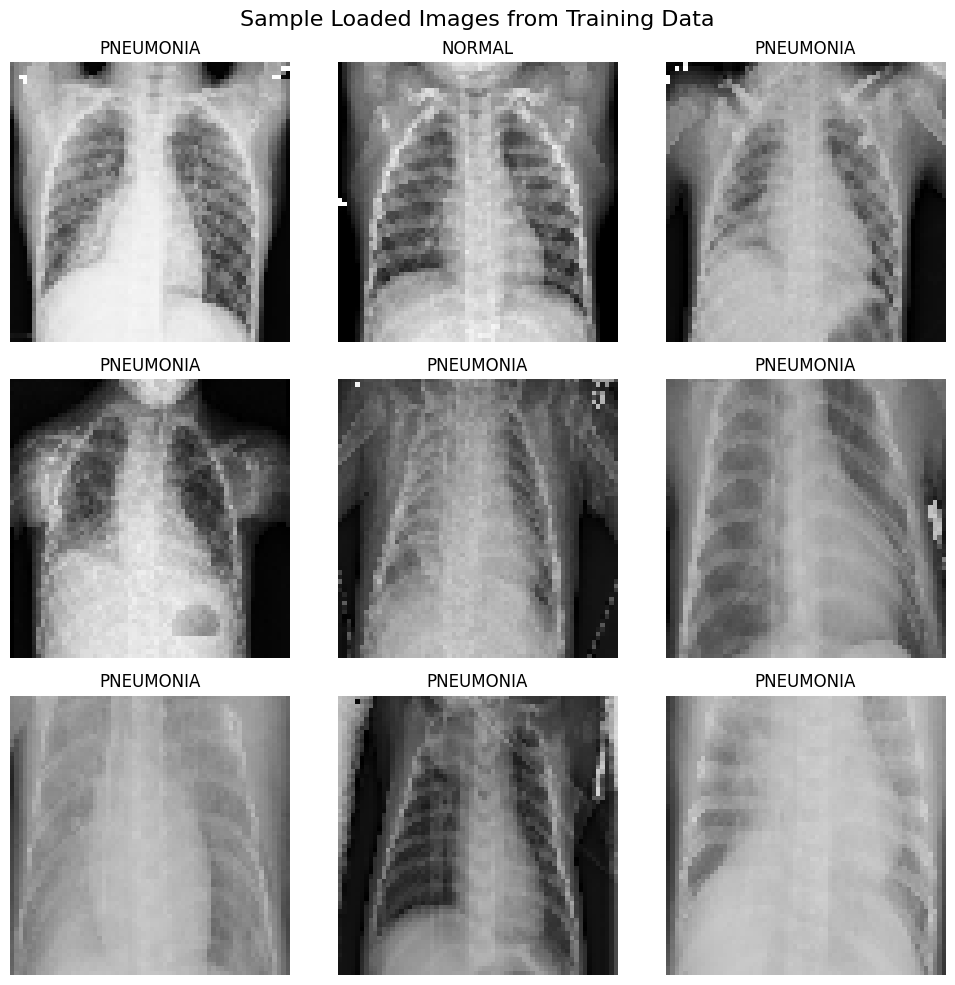

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(train_gen)  # use your training generator name

# Plot first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title('PNEUMONIA' if labels[i] == 1 else 'NORMAL')
    plt.axis('off')

plt.suptitle("Sample Loaded Images from Training Data", fontsize=16)
plt.tight_layout()
plt.show()


# Pie Plot

In [19]:
train_dir = 'chest_xray/train'

pneumonia_count = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
normal_count = len(os.listdir(os.path.join(train_dir, 'NORMAL')))


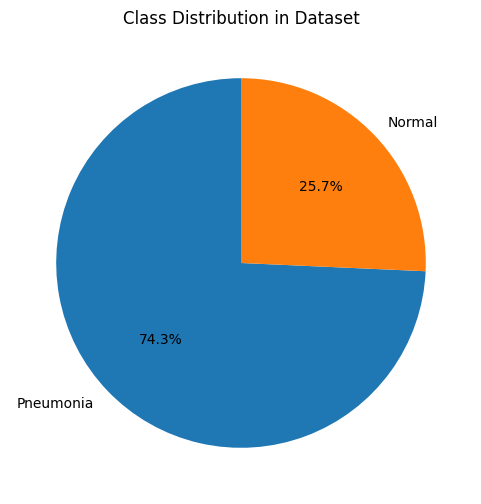

In [20]:
import matplotlib.pyplot as plt

labels = ['Pneumonia', 'Normal']
sizes = [pneumonia_count, normal_count]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution in Dataset')
plt.show()


# Box and whisker plot  

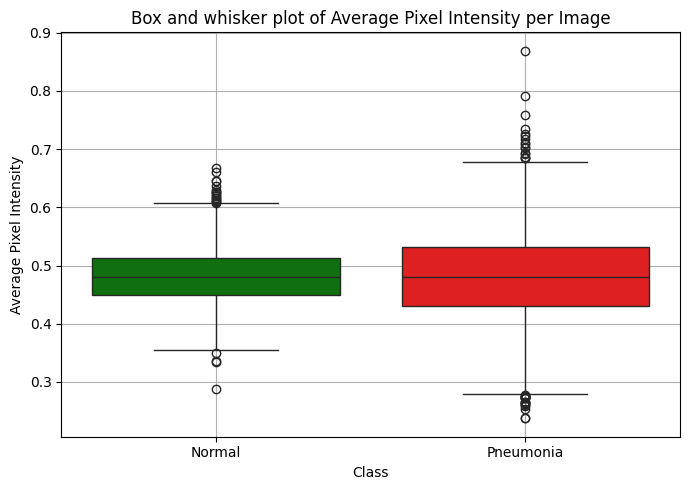

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Convert images to grayscale (if RGB)
if x_data.shape[-1] == 3:  # if RGB, convert to grayscale
    x_gray = np.mean(x_data, axis=-1)
else:
    x_gray = x_data.copy()

# Step 2: Flatten images
x_flat = x_gray.reshape(x_gray.shape[0], -1)

# Step 3: Calculate average pixel intensity per image
avg_intensity = x_flat.mean(axis=1)

# Step 4: Create DataFrame for seaborn
df = pd.DataFrame({
    'Avg Pixel Intensity': avg_intensity,
    'Label': ['Normal' if label == 0 else 'Pneumonia' for label in y_data]
})

# Step 5: Create box plot
plt.figure(figsize=(7, 5))
sns.boxplot(x='Label', y='Avg Pixel Intensity', data=df, palette=['green', 'red'])
plt.title('Box and whisker plot of Average Pixel Intensity per Image')
plt.xlabel('Class')
plt.ylabel('Average Pixel Intensity')
plt.grid(True)
plt.tight_layout()
plt.show()


## Deep learning models

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, auc

from kerastuner.tuners import Hyperband

def run_model(model_name, build_fn, preprocess_fn=None):
    print(f"\n\n🧠 Training model: {model_name.upper()}")
    x_input = preprocess_fn(x_data) if preprocess_fn else x_data
    os.makedirs('plots', exist_ok=True)

    #  Hyperparameter Tuning
    tuner = Hyperband(
        build_fn,
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='tuner_dir',
        project_name=f'pneumonia_{model_name}'
    )
    tuner.search(
        x_input, y_data,
        epochs=10,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)]
    )
    best_hp = tuner.get_best_hyperparameters(1)[0]

    print("\n🔧 Best Hyperparameters:")
    for param in best_hp.values:
        print(f"  {param}: {best_hp.get(param)}")

    # ✅ Evaluation Before CV
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
        x_input, y_data, test_size=0.2, stratify=y_data, random_state=42
    )
    model_before = tuner.hypermodel.build(best_hp)
    model_before.fit(x_train_split, y_train_split, epochs=10, batch_size=32, verbose=0)
    y_pred_val = (model_before.predict(x_val_split) > 0.5).astype('int32')

    acc_before = accuracy_score(y_val_split, y_pred_val)
    prec_before = precision_score(y_val_split, y_pred_val)
    rec_before = recall_score(y_val_split, y_pred_val)
    f1_before = f1_score(y_val_split, y_pred_val)
    

    print(f"\n📌 CLASSIFICATION BEFORE CV:")
    print(classification_report(y_val_split, y_pred_val, target_names=["Normal", "Pneumonia"]))
    model_before_cv = tuner.hypermodel.build(best_hp)
    history = model_before_cv.fit(
        x_input, y_data,
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0
    )
    #val_accuracy_before_cv = history.history['val_accuracy'][-1]
    print(f"✅ Accuracy: {acc_before:.4f}, Precision: {prec_before:.4f}, Recall: {rec_before:.4f}, F1 Score: {f1_before:.4f}")

    
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['loss'], label='Training Loss', color='red')
    plt.title(f"{model_name.upper()} - Training Accuracy & Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'plots/training_accuracy_loss_{model_name}.png')
    plt.show()

    
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f"{model_name.upper()} - Validation Accuracy & Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'plots/validation_accuracy_loss_{model_name}.png')
    plt.show()

    
    
    
    #  5-Fold Cross-Validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_preds, all_labels, all_probs = [], [], []
    fold_accuracies = []

    final_model, final_x_test, final_y_test = None, None, None

    for fold, (train_idx, test_idx) in enumerate(kf.split(x_input, y_data), 1):
        x_train, x_test = x_input[train_idx], x_input[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]

        model = tuner.hypermodel.build(best_hp)
        model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)

        probas = model.predict(x_test).flatten()
        preds = (probas > 0.5).astype("int32")

        acc = accuracy_score(y_test, preds)
        fold_accuracies.append(acc)

        print(f"✅ Fold {fold} Accuracy: {acc:.4f}")

        all_preds.extend(preds)
        all_labels.extend(y_test)
        all_probs.extend(probas)

        final_model, final_x_test, final_y_test = model, x_test, y_test

    #  Evaluation AFTER CV
    acc_after = accuracy_score(all_labels, all_preds)
    prec_after = precision_score(all_labels, all_preds)
    rec_after = recall_score(all_labels, all_preds)
    f1_after = f1_score(all_labels, all_preds)
    print(f"Accuracy : {acc_after:.4f},Precision: {prec_after:.4f}, Recall   : {rec_after:.4f},F1 Score : {f1_after:.4f}")
    
    print(f"\n📋 CLASSIFICATION REPORT AFTER CV:")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"]))
    print(f"✅ Overall Accuracy: {acc_after:.4f} ({acc_after * 100:.2f}%)")
    

    #  Evaluation Comparison Plot
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    before_scores = [acc_before, prec_before, rec_before, f1_before]
    after_scores = [acc_after, prec_after, rec_after, f1_after]

    x = np.arange(len(metrics))
    width = 0.35
    plt.figure(figsize=(8, 5))
    bars1 = plt.bar(x - width/2, before_scores, width, label='Before CV', color='skyblue')
    bars2 = plt.bar(x + width/2, after_scores, width, label='After CV', color='lightgreen')

    # Add value labels on top of bars
    for bar in bars1 + bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom', fontsize=9)

    plt.xticks(x, metrics)
    plt.ylim(0.5, 1.05)
    plt.ylabel("Score")
    plt.title(f"Evaluation Matrix of {model_name.upper()} Before and After Cross-Validation")
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f'plots/evaluation_comparison_{model_name}.png')
    plt.show()

    #  Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Pneumonia"],
                yticklabels=["Normal", "Pneumonia"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix Heatmap - {model_name.upper()}")
    plt.savefig(f'plots/confusion_matrix_{model_name}.png')
    plt.show()

    #  Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(6, 4))
    plt.plot(recall_vals, precision_vals, marker='.', label=f'AUC = {pr_auc:.4f}')
    plt.title(f'Precision-Recall Curve - {model_name.upper()}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'plots/pr_curve_{model_name}.png')
    plt.show()

    #  Random Sample Prediction
    idx = random.randint(0, len(final_y_test) - 1)
    img = final_x_test[idx]
    actual = int(final_y_test[idx])
    prediction = int((final_model.predict(final_x_test[idx:idx+1]) > 0.5)[0][0])
    class_names = ["Normal", "Pneumonia"]
    plt.imshow(img)
    plt.title(f"Actual: {class_names[actual]} | Predicted: {class_names[prediction]}")
    plt.axis('off')
    plt.savefig(f'plots/sample_prediction_{model_name}.png')
    plt.show()
    return final_model, final_x_test, final_y_test, fold_accuracies, {
    "accuracy": acc_after,
    "precision": prec_after,
    "recall": rec_after,
    "f1": f1_after
}


# 1:Convolutional Neural Network(CNN)

In [23]:
def build_cnn_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('filters', 32, 128, step=32), kernel_size=3, activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [24]:
from keras_tuner import HyperParameters; build_cnn_model(HyperParameters()).summary()



Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_37 (Flatten)                 │ (None, 30752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 64)                  │       1,968,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,969,153 (7.51 MB)

 Trainable params: 1,969,153 (7.51 MB)

 Non-trainable params: 0 (0.00 B)



🧠 Training model: CNN
Reloading Tuner from tuner_dir\pneumonia_cnn\tuner0.json

🔧 Best Hyperparameters:
  filters: 64
  dense_units: 192
  dropout: 0.4
  learning_rate: 0.001
  tuner/epochs: 10
  tuner/initial_epoch: 0
  tuner/bracket: 0
  tuner/round: 0
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

📌 CLASSIFICATION BEFORE CV:
              precision    recall  f1-score   support

      Normal       0.95      0.94      0.95       215
   Pneumonia       0.98      0.98      0.98       620

    accuracy                           0.97       835
   macro avg       0.96      0.96      0.96       835
weighted avg       0.97      0.97      0.97       835

✅ Accuracy: 0.9725, Precision: 0.9807, Recall: 0.9823, F1 Score: 0.9815


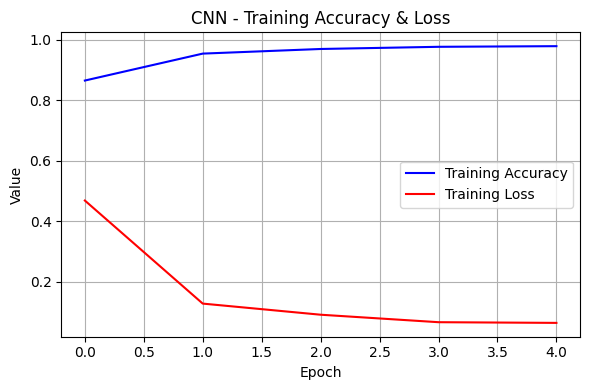

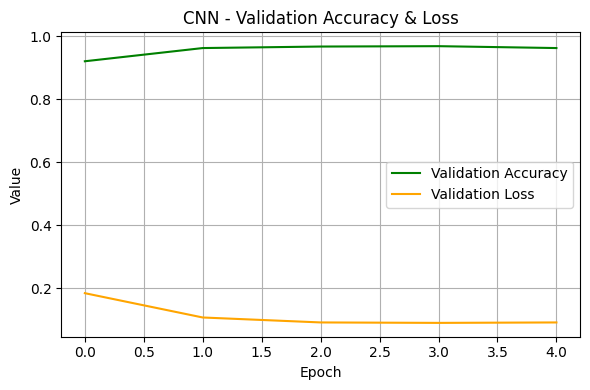

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
✅ Fold 1 Accuracy: 0.9677
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
✅ Fold 2 Accuracy: 0.9808
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
✅ Fold 3 Accuracy: 0.9725
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
✅ Fold 4 Accuracy: 0.9652
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
✅ Fold 5 Accuracy: 0.9664
Accuracy : 0.9705,Precision: 0.9816, Recall   : 0.9787,F1 Score : 0.9801

📋 CLASSIFICATION REPORT AFTER CV:
              precision    recall  f1-score   support

      Normal       0.94      0.95      0.94      1073
   Pneumonia       0.98      0.98      0.98      3100

    accuracy                           0.97      4173
   macro avg       0.96      0.96      0.96      4173
weighted avg       0.97      0.97      0.97      4173

✅ Overall Accuracy: 0.9705 (97.05%)


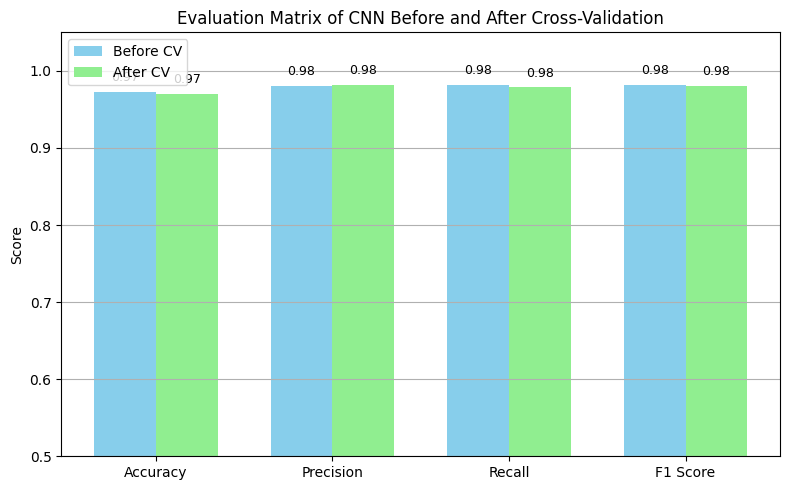

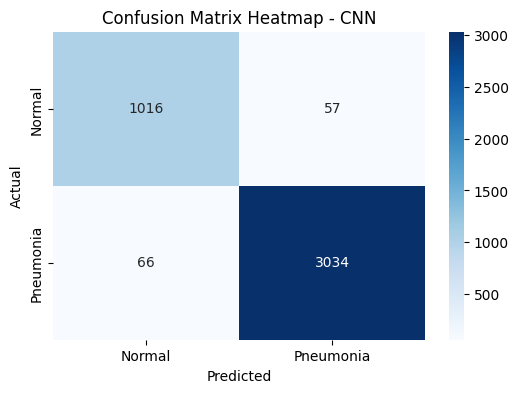

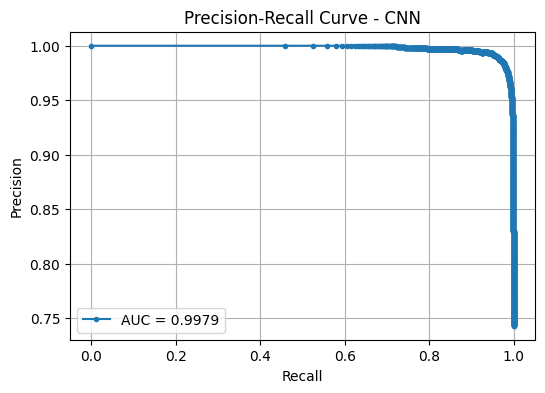

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


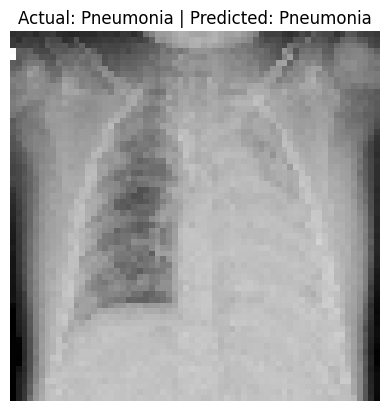

In [25]:
cnn_model, cnn_x_test, cnn_y_test, accs_cnn, cnn_metrics = run_model("cnn", build_cnn_model)

In [26]:
cnn_model.save("cnn_model.keras")

# 2. MLP (Multi-Layer Perceptron)


In [17]:
def build_mlp_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(Dense(hp.Int('dense_units1', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(Dense(hp.Int('dense_units2', 64, 256, step=64), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [18]:
build_mlp_model(HyperParameters()).summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_19 (Flatten)                 │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │         786,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 790,721 (3.02 MB)

 Trainable params: 790,721 (3.02 MB)

 Non-trainable params: 0 (0.00 B)



🧠 Training model: MLP
Reloading Tuner from tuner_dir\pneumonia_mlp\tuner0.json

🔧 Best Hyperparameters:
  dense_units1: 128
  dropout1: 0.2
  dense_units2: 256
  learning_rate: 0.001
  tuner/epochs: 10
  tuner/initial_epoch: 4
  tuner/bracket: 1
  tuner/round: 1
  tuner/trial_id: 0021
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

📌 CLASSIFICATION BEFORE CV:
              precision    recall  f1-score   support

      Normal       0.84      0.99      0.91       215
   Pneumonia       0.99      0.94      0.96       620

    accuracy                           0.95       835
   macro avg       0.92      0.96      0.94       835
weighted avg       0.96      0.95      0.95       835

✅ Accuracy: 0.9485, Precision: 0.9949, Recall: 0.9355, F1 Score: 0.9643


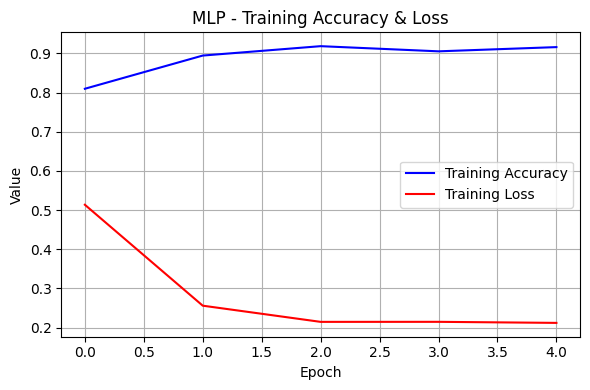

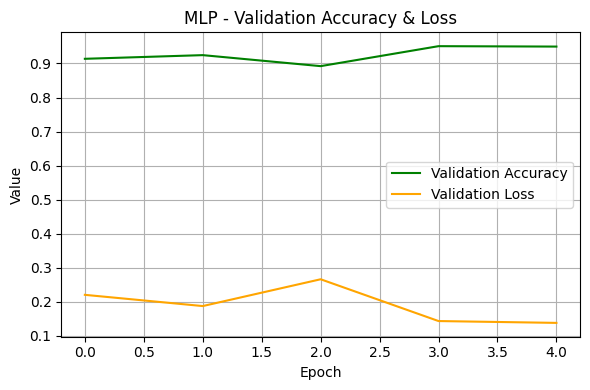

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
✅ Fold 1 Accuracy: 0.9641
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✅ Fold 2 Accuracy: 0.9533
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✅ Fold 3 Accuracy: 0.9485
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✅ Fold 4 Accuracy: 0.9652
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✅ Fold 5 Accuracy: 0.9472
Accuracy : 0.9557,Precision: 0.9755, Recall   : 0.9645,F1 Score : 0.9700

📋 CLASSIFICATION REPORT AFTER CV:
              precision    recall  f1-score   support

      Normal       0.90      0.93      0.92      1073
   Pneumonia       0.98      0.96      0.97      3100

    accuracy                           0.96      4173
   macro avg       0.94      0.95      0.94      4173
weighted avg       0.96      0.96      0.96      4173

✅ Overall Accuracy: 0.9557 (95.57%)


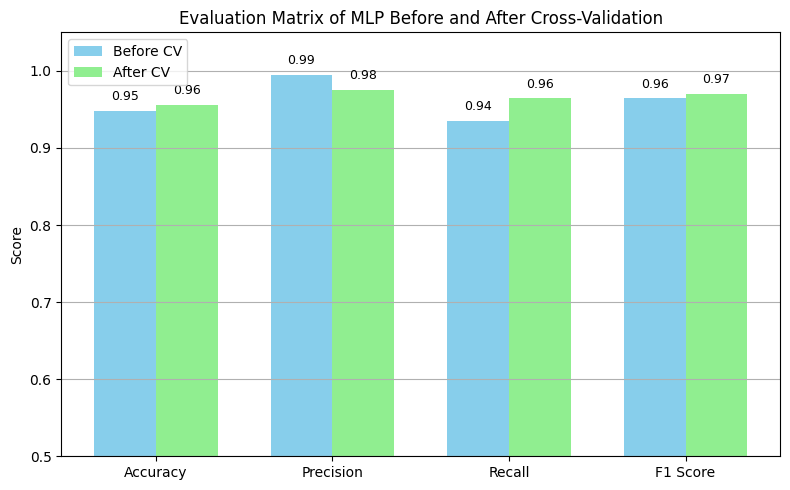

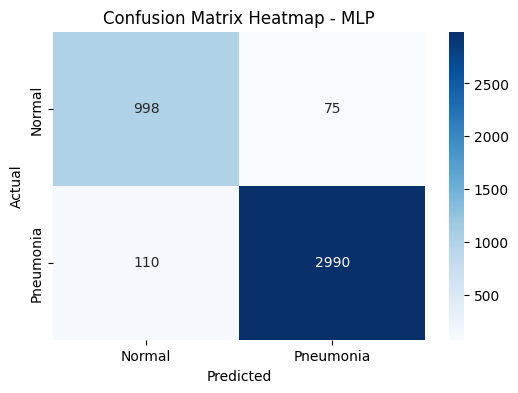

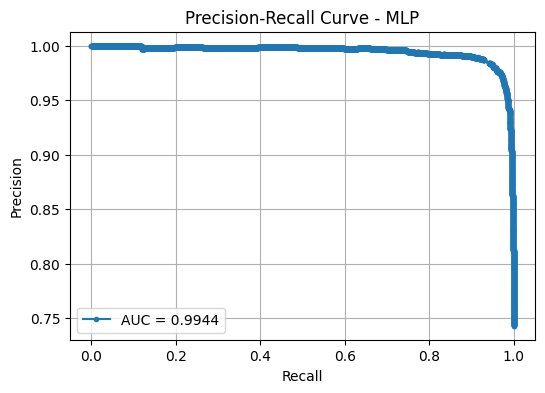

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


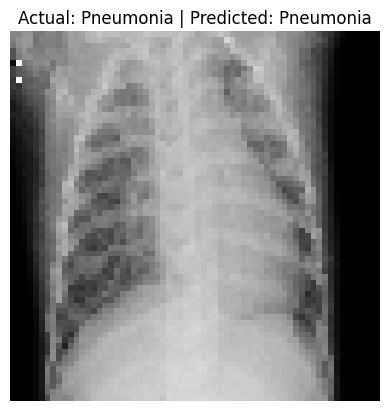

In [19]:
mlp_model, mlp_x_test, mlp_y_test, accs_mlp, mlp_metrics = run_model("mlp", build_mlp_model)


# 3.MobileNet Model

In [20]:
def build_mobilenet_model(hp):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights='imagenet')
    base_model.trainable = False
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
    x = tf.keras.layers.Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [21]:
build_mobilenet_model(HyperParameters()).summary()

Model: "functional_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)   │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 32, 32, 32)        │             864 │ input_layer_27[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 32, 32, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 32, 32, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 32, 32, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 32, 32, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 32, 32, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 32, 32, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 32, 32, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 32, 32, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 32, 32, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 32, 32, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 33, 33, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 16, 16, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)



🧠 Training model: MOBILENET
Reloading Tuner from tuner_dir\pneumonia_mobilenet\tuner0.json

🔧 Best Hyperparameters:
  dropout: 0.2
  dense_units: 128
  learning_rate: 0.001
  tuner/epochs: 10
  tuner/initial_epoch: 4
  tuner/bracket: 2
  tuner/round: 2
  tuner/trial_id: 0013
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step

📌 CLASSIFICATION BEFORE CV:
              precision    recall  f1-score   support

      Normal       0.89      0.87      0.88       215
   Pneumonia       0.96      0.96      0.96       620

    accuracy                           0.94       835
   macro avg       0.92      0.92      0.92       835
weighted avg       0.94      0.94      0.94       835

✅ Accuracy: 0.9401, Precision: 0.9567, Recall: 0.9629, F1 Score: 0.9598


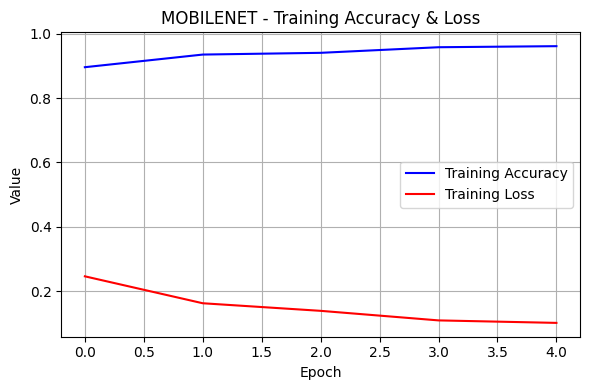

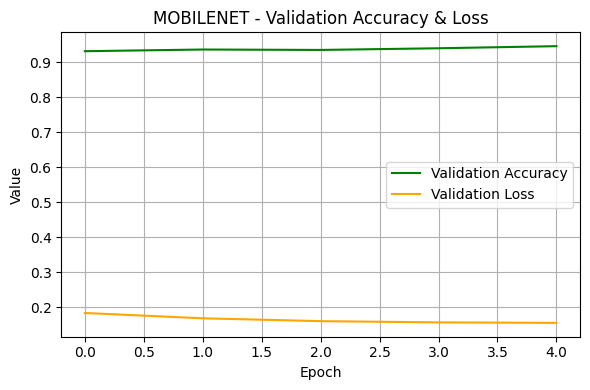

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step
✅ Fold 1 Accuracy: 0.9521
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step
✅ Fold 2 Accuracy: 0.9341
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step
✅ Fold 3 Accuracy: 0.9234
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step
✅ Fold 4 Accuracy: 0.9376
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step
✅ Fold 5 Accuracy: 0.9293
Accuracy : 0.9353,Precision: 0.9670, Recall   : 0.9452,F1 Score : 0.9560

📋 CLASSIFICATION REPORT AFTER CV:
              precision    recall  f1-score   support

      Normal       0.85      0.91      0.88      1073
   Pneumonia       0.97      0.95      0.96      3100

    accuracy                           0.94      4173
   macro avg       0.91      0.93      0.92      4173
weighted avg       0.94      0.94      0.94      4173

✅ Overall Accuracy: 0.9353 (93.53%)


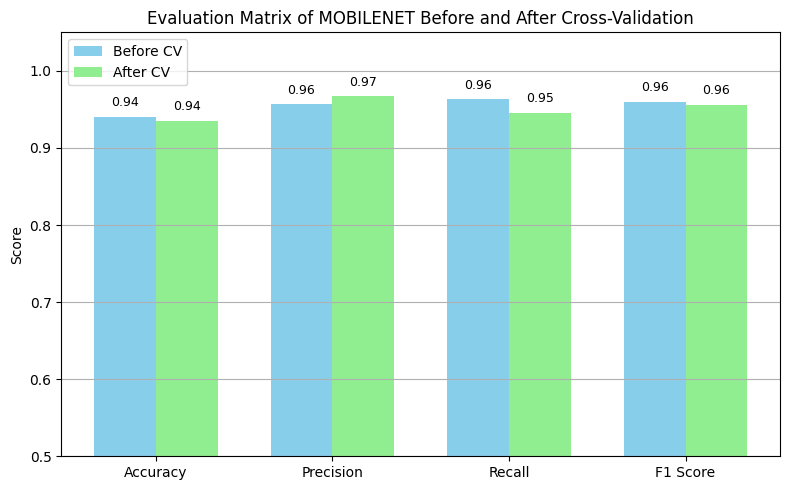

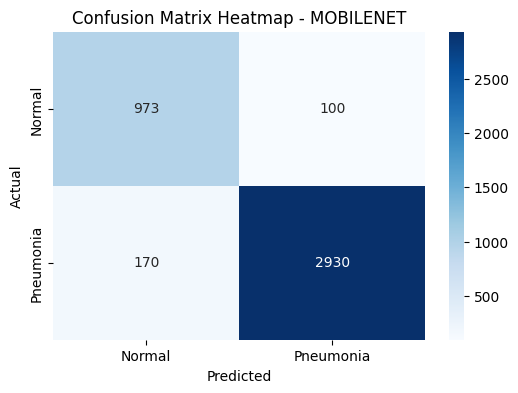

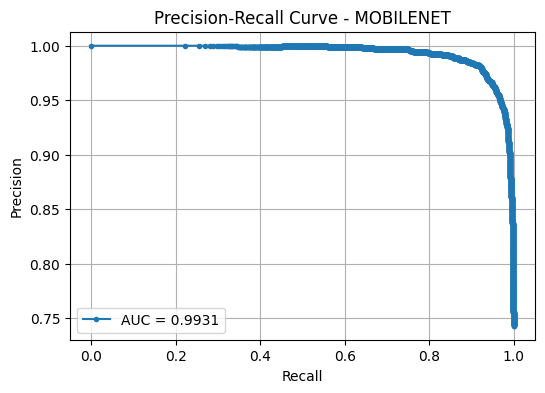

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


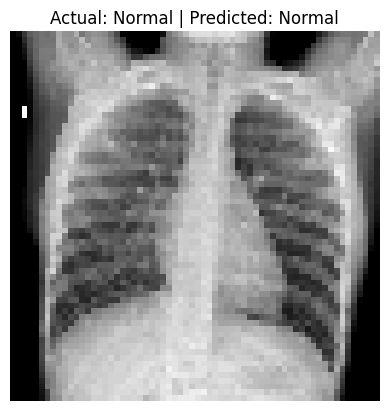

In [22]:
mobilenet_model, mobilenet_x_test, mobilenet_y_test, accs_mobilenet, mobilenet_metrics= run_model("mobilenet", build_mobilenet_model)


# 4.VGG16 Model

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_vgg16_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)

    # Tunable dense layer
    x = Dense(hp.Int('dense_units1', 64, 256, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1))(x)

    # Optional second dense layer
    x = Dense(hp.Int('dense_units2', 64, 256, step=64), activation='relu')(x)
    
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [24]:
build_vgg16_model(HyperParameters()).summary()

Model: "functional_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,850,049 (56.65 MB)

 Trainable params: 135,361 (528.75 KB)

 Non-trainable params: 14,714,688 (56.13 MB)



🧠 Training model: VGG16
Reloading Tuner from tuner_dir\pneumonia_vgg16\tuner0.json

🔧 Best Hyperparameters:
  dense_units1: 192
  dropout1: 0.30000000000000004
  dense_units2: 64
  learning_rate: 0.001
  tuner/epochs: 10
  tuner/initial_epoch: 4
  tuner/bracket: 2
  tuner/round: 2
  tuner/trial_id: 0012
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 546ms/step

📌 CLASSIFICATION BEFORE CV:
              precision    recall  f1-score   support

      Normal       0.93      0.94      0.94       215
   Pneumonia       0.98      0.98      0.98       620

    accuracy                           0.97       835
   macro avg       0.96      0.96      0.96       835
weighted avg       0.97      0.97      0.97       835

✅ Accuracy: 0.9677, Precision: 0.9806, Recall: 0.9758, F1 Score: 0.9782


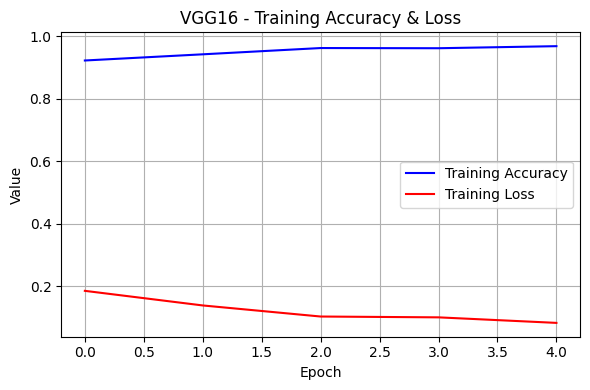

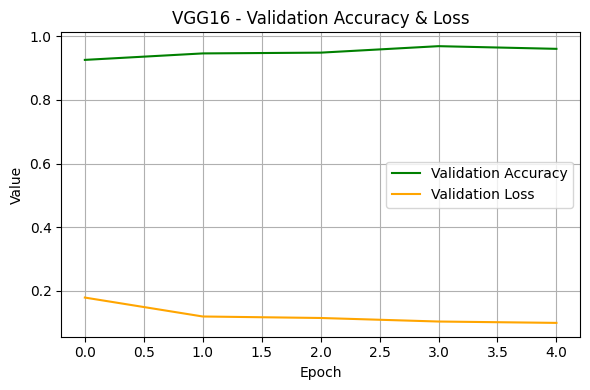

27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 546ms/step
✅ Fold 1 Accuracy: 0.9629
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 555ms/step
✅ Fold 2 Accuracy: 0.9737
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 564ms/step
✅ Fold 3 Accuracy: 0.9713
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 569ms/step
✅ Fold 4 Accuracy: 0.9724
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 558ms/step
✅ Fold 5 Accuracy: 0.9700
Accuracy : 0.9700,Precision: 0.9781, Recall   : 0.9816,F1 Score : 0.9799

📋 CLASSIFICATION REPORT AFTER CV:
              precision    recall  f1-score   support

      Normal       0.95      0.94      0.94      1073
   Pneumonia       0.98      0.98      0.98      3100

    accuracy                           0.97      4173
   macro avg       0.96      0.96      0.96      4173
weighted avg       0.97      0.97      0.97      4173

✅ Overall Accuracy: 0.9700 (97.00%)


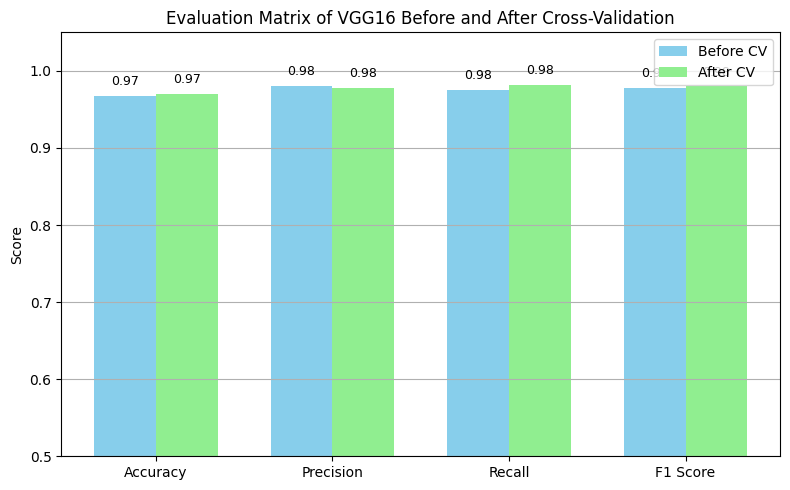

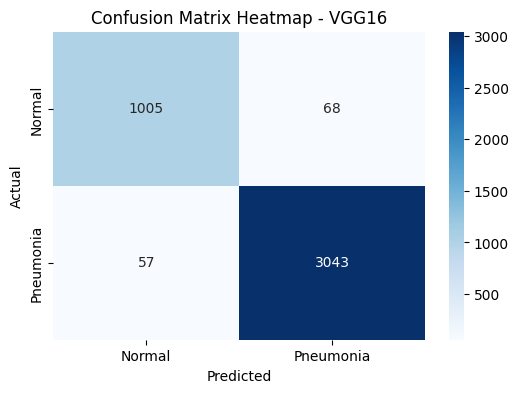

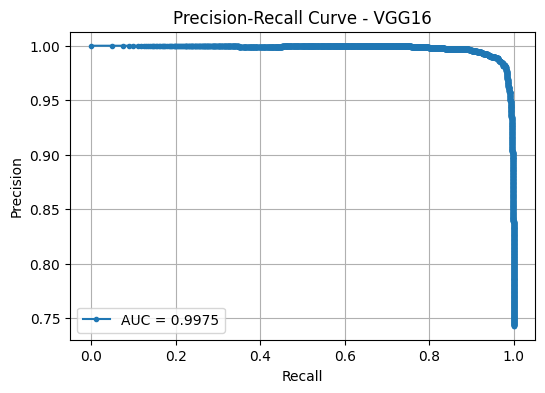

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


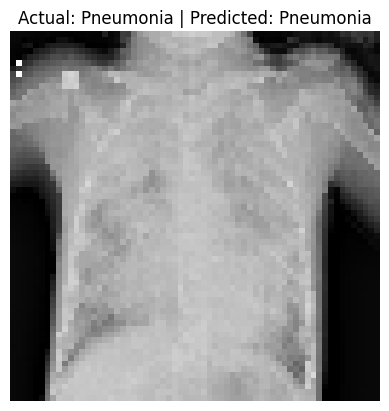

In [25]:
vgg16_model, vgg16_x_test, vgg16_y_test, accs_vgg16, vgg16_metrics = run_model("vgg16", build_vgg16_model)


In [26]:
results=({
    "cnn": cnn_metrics,
    "mlp": mlp_metrics,
    "mobilenet":mobilenet_metrics,
    "vgg16":vgg16_metrics
})

## Machine learning models

In [27]:
from sklearn.decomposition import PCA
# Step 1: Flatten image data
x_flat = x_data.reshape(len(x_data), -1)

# Step 2: Apply PCA
pca = PCA(n_components=100)  # You can change 100 to 50, 150, etc.
x_pca = pca.fit_transform(x_flat)

print(f"Original shape: {x_flat.shape}")
print(f"PCA reduced shape: {x_pca.shape}")


Original shape: (4173, 12288)
PCA reduced shape: (4173, 100)


# Scatter Plot

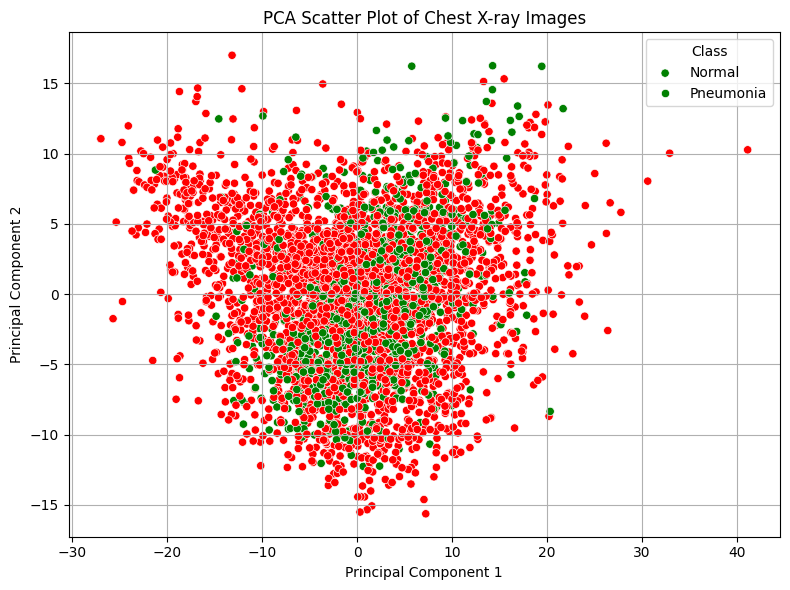

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Flatten each image (convert from 64x64x3 to 1D)
x_flat = x_data.reshape(x_data.shape[0], -1)

# Reduce to 2D with PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_flat)

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1], hue=y_data, palette=['green', 'red'])
plt.title('PCA Scatter Plot of Chest X-ray Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class', labels=['Normal', 'Pneumonia'])
plt.grid(True)
plt.tight_layout()
plt.show()


# Load Images

In [29]:
import os
import glob
import cv2
import numpy as np

# Step 1: Load image paths
data_dir = "chest_xray/train" #  update this path
image_paths = glob.glob(os.path.join(data_dir, "**", "*.jpeg"), recursive=True)

# Step 2: Load images and labels
all_images = []
labels = []

for path in image_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # use IMREAD_COLOR for RGB
    img = cv2.resize(img, (64, 64))
    all_images.append(img)
    label = 0 if "NORMAL" in path.upper() else 1  # label: 0 = Normal, 1 = Pneumonia
    labels.append(label)

# Step 3: Convert to array
image_data = np.array(all_images)
x_data = image_data.reshape(len(image_data), -1)
y_data = np.array(labels)

# Step 4: PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
x_pca = pca.fit_transform(x_data)

# Correlation Matrix

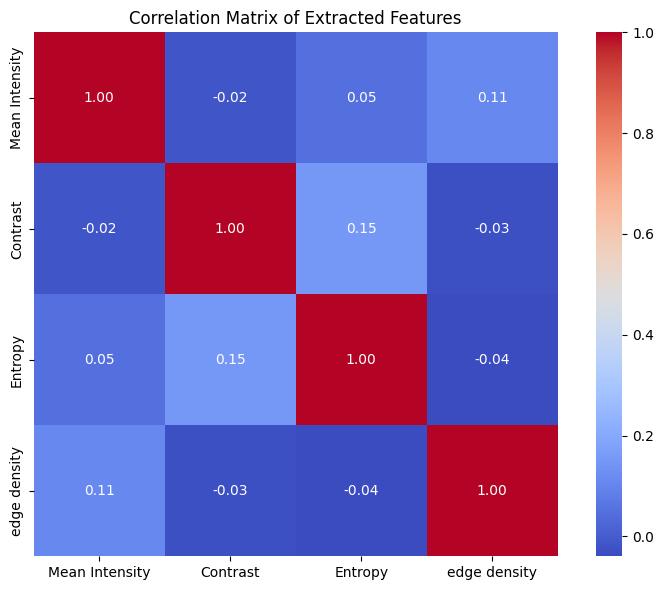

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  Example features — replace with your actual features
# If you already have them from the ML code, just reuse
mean_intensity = np.random.rand(100)
contrast = np.random.rand(100)
entropy = np.random.rand(100)
edge_density=np.random.rand(100)

#  Create DataFrame from features
df_features = pd.DataFrame({
    'Mean Intensity': mean_intensity,
    'Contrast': contrast,
    'Entropy': entropy,
    'edge density': edge_density
})

#  Correlation matrix
correlation_matrix = df_features.corr()

#  Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Extracted Features")
plt.tight_layout()
plt.show()

In [31]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def run_model_classical(model, model_name, x_data, y_data,image_data=None):
    print(f"\n🔍 Running: {model_name.upper()}")

    #  Evaluation Before Cross-Validation 
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
        x_data, y_data, test_size=0.2, stratify=y_data, random_state=42
    )
    model.fit(x_train_split, y_train_split)
    y_pred_val = model.predict(x_val_split)

    acc_before = accuracy_score(y_val_split, y_pred_val)
    prec_before = precision_score(y_val_split, y_pred_val)
    rec_before = recall_score(y_val_split, y_pred_val)
    f1_before = f1_score(y_val_split, y_pred_val)

    print("\n📌 CLASSIFICATION REPORT BEFORE CV:")
    print(classification_report(y_val_split, y_pred_val, target_names=["Normal", "Pneumonia"]))
    print(f" Accuracy: {acc_before:.4f}, Precision: {prec_before:.4f}, Recall: {rec_before:.4f}, F1 Score: {f1_before:.4f}")
    

    #  Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_preds, all_labels = [], []
    fold_accuracies = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(x_data, y_data), 1):
        x_train, x_test = x_data[train_idx], x_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]

        model.fit(x_train, y_train)
        preds = model.predict(x_test)

        acc = accuracy_score(y_test, preds)
        fold_accuracies.append(acc)
        all_preds.extend(preds)
        all_labels.extend(y_test)

        print(f"✅ Fold {fold} Accuracy: {acc:.4f}")

    #  Final Evaluation After CV
    acc_after = accuracy_score(all_labels, all_preds)
    prec_after = precision_score(all_labels, all_preds)
    rec_after = recall_score(all_labels, all_preds)
    f1_after = f1_score(all_labels, all_preds)

    print("\n📋 CLASSIFICATION REPORT AFTER CV:")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"]))
    print(f" Accuracy: {acc_after:.4f}, Precision: {prec_after:.4f}, Recall: {rec_after:.4f}, F1 Score: {f1_after:.4f}")
    print(f" Overall CV Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")

     # Before vs After CV Bar Chart
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    before_scores = [acc_before, prec_before, rec_before, f1_before]
    after_scores = [acc_after, prec_after, rec_after, f1_after]

    x = np.arange(len(metrics))
    width = 0.35
    plt.figure(figsize=(8, 5))
    bars1 = plt.bar(x - width/2, before_scores, width, label='Before CV', color='skyblue')
    bars2 = plt.bar(x + width/2, after_scores, width, label='After CV', color='lightgreen')

    for bar in bars1 + bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom', fontsize=9)

    plt.xticks(x, metrics)
    plt.ylim(0.4, 1.05)
    plt.ylabel("Score")
    plt.title(f"{model_name.upper()} Evaluation Metrics Before and After CV")
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"{model_name}_eval_comparison.png")
    plt.show()

    #  Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.title(f"Confusion Matrix Heatmap - {model_name.upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()

    #  Precision-Recall Curve
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(x_data)[:, 1]
    elif hasattr(model, "decision_function"):
        probs = model.decision_function(x_data)
    else:
        probs = np.array(all_preds)  # fallback

    precision_vals, recall_vals, _ = precision_recall_curve(y_data, probs)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(6, 4))
    plt.plot(recall_vals, precision_vals, marker='.', color='blue', label=f'AUC = {pr_auc:.4f}')
    plt.title(f'Precision-Recall Curve - {model_name.upper()}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"{model_name}_precision_recall_curve.png")
    plt.show()

     #  Random Sample Prediction
    import random
    idx = random.randint(0, len(x_data) - 1)
    sample = x_data[idx].reshape(1, -1)
    true_label = y_data[idx]
    predicted_label = model.predict(sample)[0]

    print("\n  RANDOM SAMPLE PREDICTION")
    print(f"➡️ Sample Index: {idx}")
    print(f"✅ Actual Label: {'Pneumonia' if true_label == 1 else 'Normal'}")
    print(f"🔮 Predicted Label: {'Pneumonia' if predicted_label == 1 else 'Normal'}")
        #  Show Random Image (if image_data is available)
    if image_data is not None:
        plt.figure(figsize=(3, 3))
        plt.imshow(image_data[idx], cmap='gray')  # or remove cmap='gray' for color images
        plt.axis('off')
        plt.title(f"True: {'Pneumonia' if true_label == 1 else 'Normal'} | Predicted: {'Pneumonia' if predicted_label == 1 else 'Normal'}")
        plt.show()
    else:
        print("⚠️ 'image_data' not found. Cannot display the image.")


    return {
    "model": model,
    "fold_accuracies": fold_accuracies,
    "metrics_after_cv": {
        "accuracy": acc_after,
        "precision": prec_after,
        "recall": rec_after,
        "f1": f1_after
    }
}



# 5. Gradient Boost Classifier

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


🔍 Running: GRADIENTBOOST_PCA

📌 CLASSIFICATION REPORT BEFORE CV:
              precision    recall  f1-score   support

      Normal       0.93      0.86      0.90       268
   Pneumonia       0.95      0.98      0.97       776

    accuracy                           0.95      1044
   macro avg       0.94      0.92      0.93      1044
weighted avg       0.95      0.95      0.95      1044

 Accuracy: 0.9483, Precision: 0.9535, Recall: 0.9781, F1 Score: 0.9656
✅ Fold 1 Accuracy: 0.9454
✅ Fold 2 Accuracy: 0.9396
✅ Fold 3 Accuracy: 0.9377
✅ Fold 4 Accuracy: 0.9473
✅ Fold 5 Accuracy: 0.9453

📋 CLASSIFICATION REPORT AFTER CV:
              precision    recall  f1-score   support

      Normal       0.92      0.85      0.88      1341
   Pneumonia       0.95      0.98      0.96      3875

    accuracy                           0.94      5216
   macro avg       0.94      0.91      0.92      5216
weighted avg       0.94      0.94      0.94      5216

 Accuracy: 0.9431, Precision: 0.9490, Recall

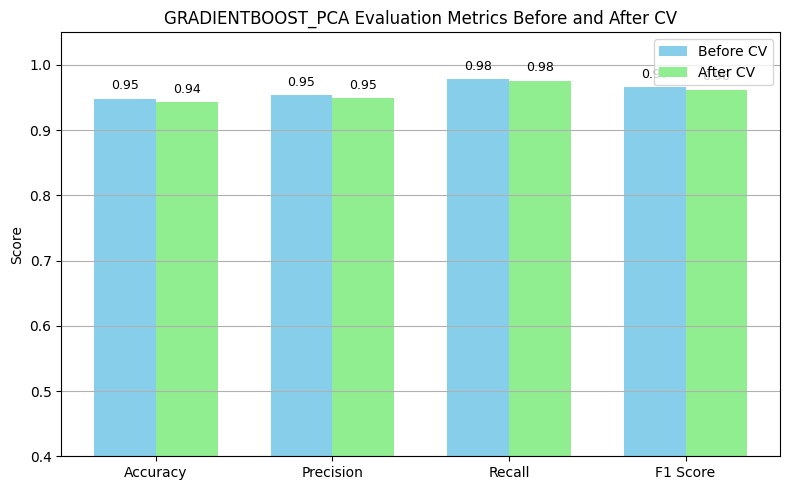

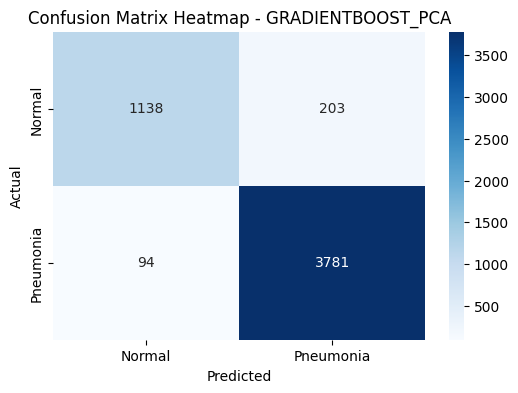

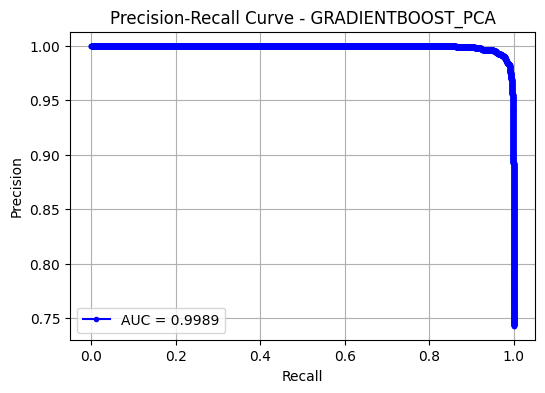


  RANDOM SAMPLE PREDICTION
➡️ Sample Index: 90
✅ Actual Label: Normal
🔮 Predicted Label: Normal


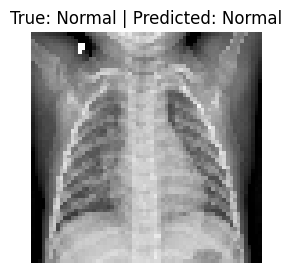

In [34]:
# Run GradientBoostingClassifier with PCA
accs_gb= run_model_classical(GradientBoostingClassifier(), "GradientBoost_PCA", x_pca, y_data, image_data=image_data)

# 6.  Decision Tree Classifier


🔍 Running: DECISIONTREE_PCA

📌 CLASSIFICATION REPORT BEFORE CV:
              precision    recall  f1-score   support

      Normal       0.77      0.74      0.76       268
   Pneumonia       0.91      0.92      0.92       776

    accuracy                           0.88      1044
   macro avg       0.84      0.83      0.84      1044
weighted avg       0.88      0.88      0.88      1044

 Accuracy: 0.8764, Precision: 0.9121, Recall: 0.9227, F1 Score: 0.9174
✅ Fold 1 Accuracy: 0.8812
✅ Fold 2 Accuracy: 0.8869
✅ Fold 3 Accuracy: 0.8734
✅ Fold 4 Accuracy: 0.8782
✅ Fold 5 Accuracy: 0.8849

📋 CLASSIFICATION REPORT AFTER CV:
              precision    recall  f1-score   support

      Normal       0.77      0.77      0.77      1341
   Pneumonia       0.92      0.92      0.92      3875

    accuracy                           0.88      5216
   macro avg       0.84      0.84      0.84      5216
weighted avg       0.88      0.88      0.88      5216

 Accuracy: 0.8809, Precision: 0.9200, Recall:

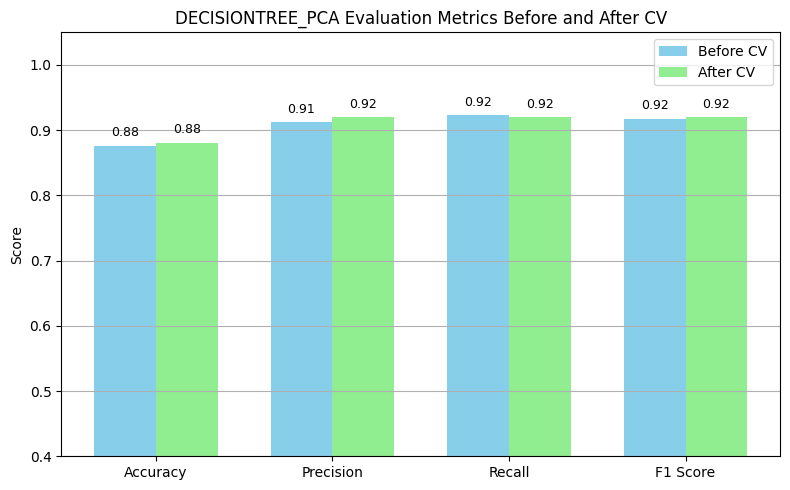

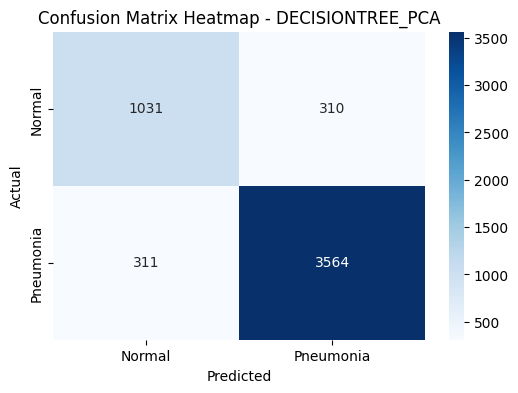

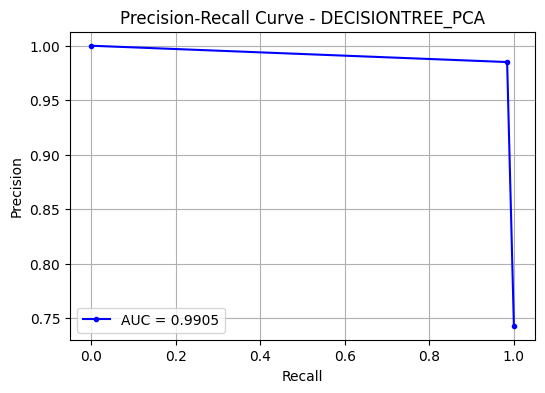


  RANDOM SAMPLE PREDICTION
➡️ Sample Index: 552
✅ Actual Label: Normal
🔮 Predicted Label: Normal


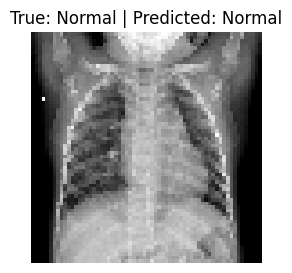

In [37]:
#Run decision tree with PCA
accs_dt = run_model_classical(DecisionTreeClassifier(), "DecisionTree_PCA", x_pca, y_data,image_data=image_data)

# 7. KNN (K-Nearest Neighbors)


🔍 Running: KNN_PCA

📌 CLASSIFICATION REPORT BEFORE CV:
              precision    recall  f1-score   support

      Normal       0.91      0.91      0.91       268
   Pneumonia       0.97      0.97      0.97       776

    accuracy                           0.96      1044
   macro avg       0.94      0.94      0.94      1044
weighted avg       0.96      0.96      0.96      1044

 Accuracy: 0.9559, Precision: 0.9704, Recall: 0.9704, F1 Score: 0.9704
✅ Fold 1 Accuracy: 0.9502
✅ Fold 2 Accuracy: 0.9444
✅ Fold 3 Accuracy: 0.9521
✅ Fold 4 Accuracy: 0.9415
✅ Fold 5 Accuracy: 0.9406

📋 CLASSIFICATION REPORT AFTER CV:
              precision    recall  f1-score   support

      Normal       0.91      0.88      0.89      1341
   Pneumonia       0.96      0.97      0.96      3875

    accuracy                           0.95      5216
   macro avg       0.93      0.92      0.93      5216
weighted avg       0.95      0.95      0.95      5216

 Accuracy: 0.9457, Precision: 0.9577, Recall: 0.9698, 

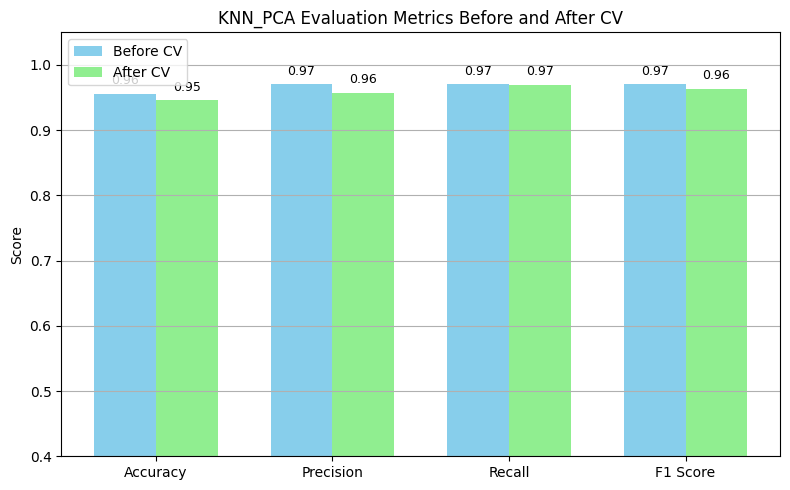

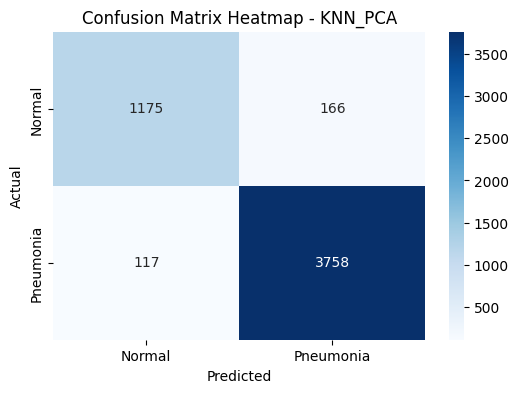

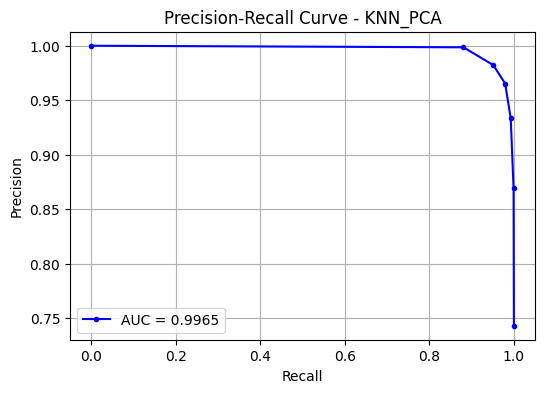


  RANDOM SAMPLE PREDICTION
➡️ Sample Index: 3286
✅ Actual Label: Pneumonia
🔮 Predicted Label: Pneumonia


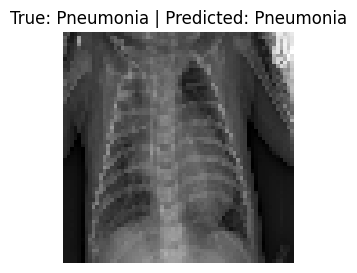

In [39]:
#run knn with PCA
accs_knn = run_model_classical(KNeighborsClassifier(), "KNN_PCA", x_pca, y_data,image_data=image_data)

#  8. Gaussian Naive Bayes Classifier


🔍 Running: NAIVEBAYES_PCA

📌 CLASSIFICATION REPORT BEFORE CV:
              precision    recall  f1-score   support

      Normal       0.66      0.80      0.73       268
   Pneumonia       0.93      0.86      0.89       776

    accuracy                           0.84      1044
   macro avg       0.79      0.83      0.81      1044
weighted avg       0.86      0.84      0.85      1044

 Accuracy: 0.8448, Precision: 0.9264, Recall: 0.8595, F1 Score: 0.8917
✅ Fold 1 Accuracy: 0.8295
✅ Fold 2 Accuracy: 0.8523
✅ Fold 3 Accuracy: 0.8476
✅ Fold 4 Accuracy: 0.8667
✅ Fold 5 Accuracy: 0.8207

📋 CLASSIFICATION REPORT AFTER CV:
              precision    recall  f1-score   support

      Normal       0.67      0.76      0.71      1341
   Pneumonia       0.91      0.87      0.89      3875

    accuracy                           0.84      5216
   macro avg       0.79      0.82      0.80      5216
weighted avg       0.85      0.84      0.85      5216

 Accuracy: 0.8434, Precision: 0.9121, Recall: 0

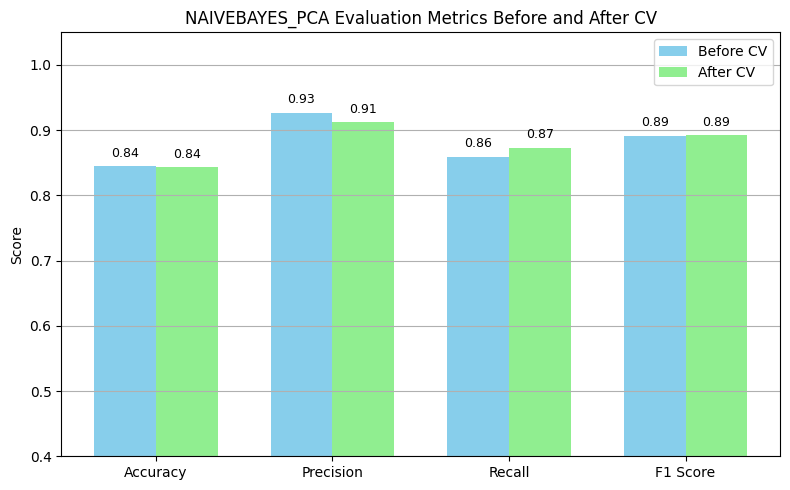

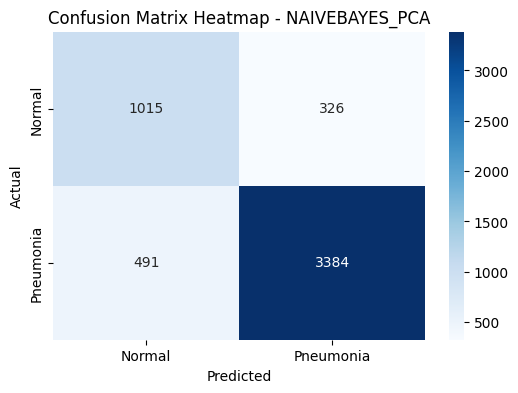

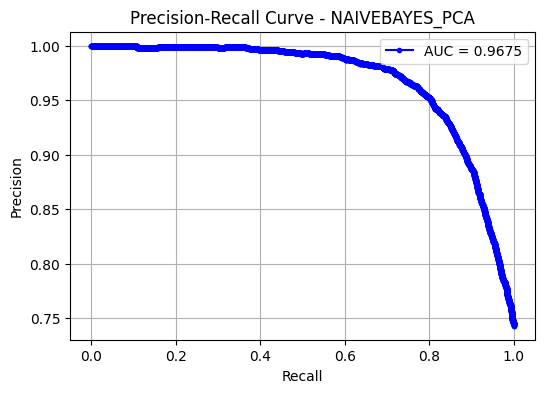


  RANDOM SAMPLE PREDICTION
➡️ Sample Index: 4626
✅ Actual Label: Pneumonia
🔮 Predicted Label: Pneumonia


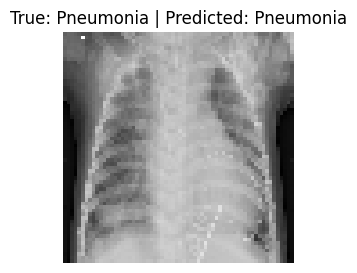

In [41]:
# Run NaiveBayes with PCA
accs_nb = run_model_classical(GaussianNB(), "NaiveBayes_PCA", x_pca, y_data,image_data=image_data)

In [44]:
results.update({
    "Gradient Boost": accs_gb["metrics_after_cv"],
    "Decision Tree": accs_dt["metrics_after_cv"],
    "KNN": accs_knn["metrics_after_cv"],
    "Naive Bayes": accs_nb["metrics_after_cv"]
})

# Model Comparison Table

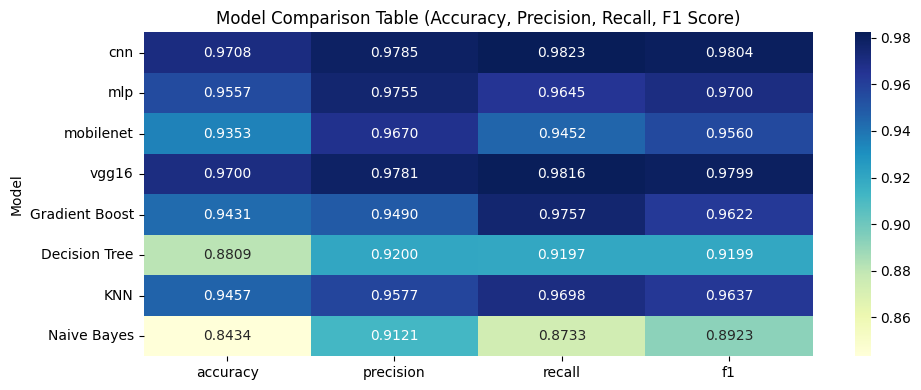


📋 Model Comparison Table:

                accuracy  precision  recall      f1
cnn               0.9708     0.9785  0.9823  0.9804
mlp               0.9557     0.9755  0.9645  0.9700
mobilenet         0.9353     0.9670  0.9452  0.9560
vgg16             0.9700     0.9781  0.9816  0.9799
Gradient Boost    0.9431     0.9490  0.9757  0.9622
Decision Tree     0.8809     0.9200  0.9197  0.9199
KNN               0.9457     0.9577  0.9698  0.9637
Naive Bayes       0.8434     0.9121  0.8733  0.8923


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Create DataFrame from your results dictionary
results_df = pd.DataFrame(results).T  # Transpose so models are rows
results_df = results_df[['accuracy', 'precision', 'recall', 'f1']]  # Reorder columns

#  Save as CSV (optional)
results_df.to_csv("model_comparison_table.csv")

#  Display as a heatmap table
plt.figure(figsize=(10, 4))
sns.heatmap(results_df, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title("Model Comparison Table (Accuracy, Precision, Recall, F1 Score)")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("plots/model_comparison_table.png")
plt.show()

#  Print neatly in console too
print("\n📋 Model Comparison Table:\n")
print(results_df.round(4))


# Model Comparision Graph

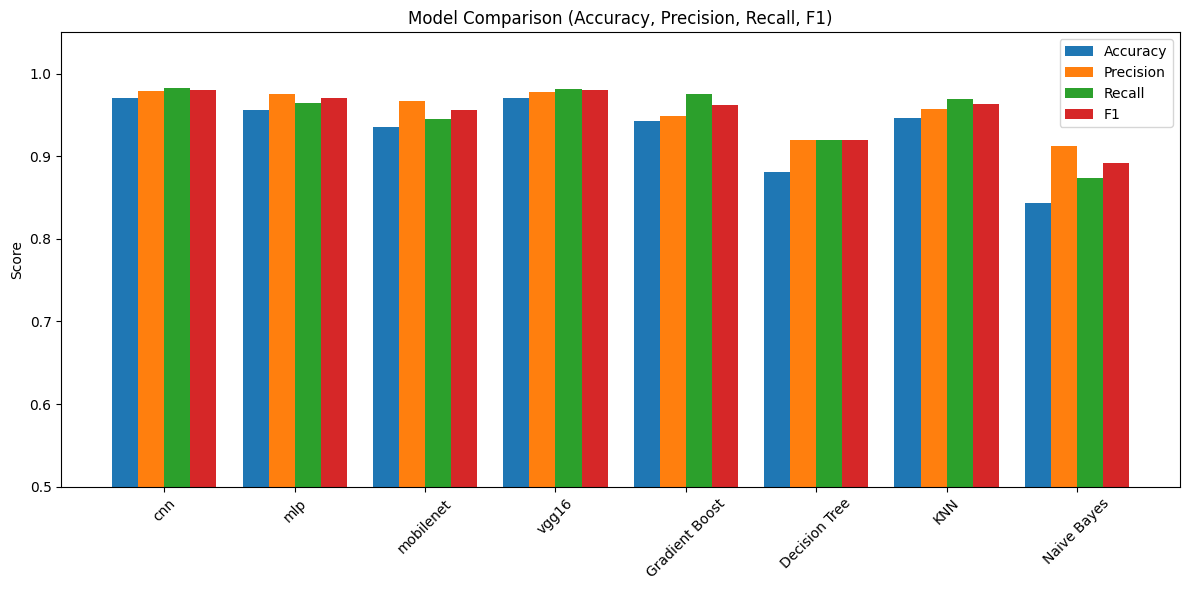

In [46]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'precision', 'recall', 'f1']
model_names = list(results.keys())

plt.figure(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(model_names))

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in model_names]
    plt.bar(x + i*bar_width, values, width=bar_width, label=metric.capitalize())

plt.xticks(x + bar_width * 1.5, model_names, rotation=45)
plt.ylim(0.5, 1.05)
plt.ylabel("Score")
plt.title("Model Comparison (Accuracy, Precision, Recall, F1)")
plt.legend()
plt.tight_layout()
plt.savefig("plots/model_comparison_metrics.png")
plt.show()


# Best Model

In [47]:
average_scores = {
    model: np.mean([metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']])
    for model, metrics in results.items()
}
best_overall_model = max(average_scores.items(), key=lambda x: x[1])

# Print best overall model at the top
print(f"\n Best Overall Model: {best_overall_model[0]} (Average Score: {best_overall_model[1]:.4f})")

# Print best model for each metric
print("\n Best Model per Metric:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    best_model = max(results.items(), key=lambda x: x[1][metric])
    print(f"{metric.capitalize():<10}: {best_model[0]} ({best_model[1][metric]:.4f})")


 Best Overall Model: cnn (Average Score: 0.9780)

 Best Model per Metric:
Accuracy  : cnn (0.9708)
Precision : cnn (0.9785)
Recall    : cnn (0.9823)
F1        : cnn (0.9804)


# Predict External Chest X-ray Image

In [49]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(64, 64)):
    # Load image and resize
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

img_input = load_and_preprocess_image(r"C:\Users\rehan\Downloads\images (31).jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
🔍 Predicted Class: PNEUMONIA (0.6323 confidence)


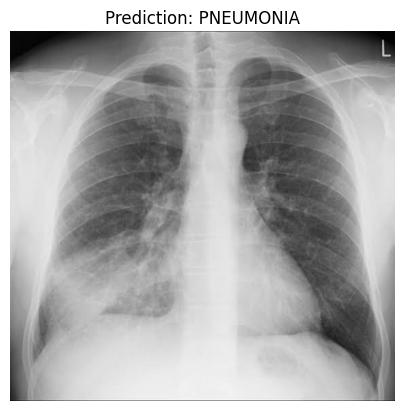

In [50]:
prediction = cnn_model.predict(img_input)[0][0]  # probability
label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"

print(f"🔍 Predicted Class: {label} ({prediction:.4f} confidence)")

# Plot the image with prediction
plt.imshow(image.load_img(r"C:\Users\rehan\Downloads\images (31).jpeg"))
plt.title(f"Prediction: {label}")
plt.axis('off')
plt.show()

In [51]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(64, 64)):
    # Load image and resize
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

img_input = load_and_preprocess_image(r"C:\Users\rehan\Downloads\Pneumonia_images (32).jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
🔍 Predicted Class: PNEUMONIA (0.6323 confidence)


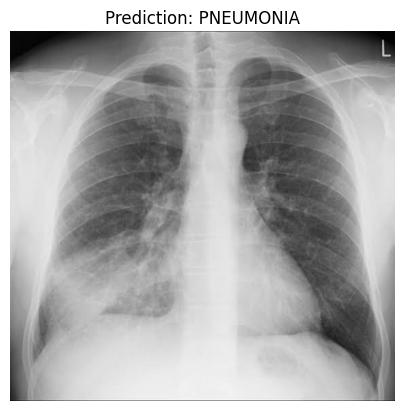

In [52]:
prediction = cnn_model.predict(img_input)[0][0]  # probability
label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"

print(f"🔍 Predicted Class: {label} ({prediction:.4f} confidence)")

# Plot the image with prediction
plt.imshow(image.load_img(r"C:\Users\rehan\Downloads\Pneumonia_images (32).jpeg"))
plt.title(f"Prediction: {label}")
plt.axis('off')
plt.show()

In [53]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(64, 64)):
    # Load image and resize
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

img_input = load_and_preprocess_image(r"C:\Users\rehan\Downloads\normal_images (35).jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
🔍 Predicted Class: NORMAL (0.1597 confidence)


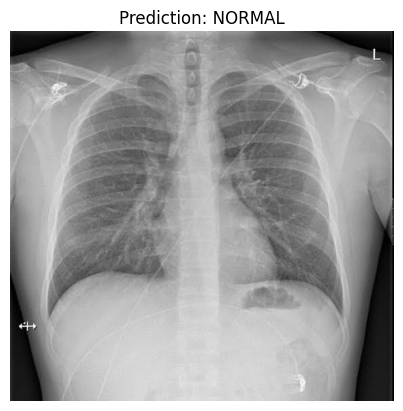

In [54]:
prediction = cnn_model.predict(img_input)[0][0]  # probability
label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"

print(f"🔍 Predicted Class: {label} ({prediction:.4f} confidence)")

# Plot the image with prediction
plt.imshow(image.load_img(r"C:\Users\rehan\Downloads\normal_images (35).jpeg"))
plt.title(f"Prediction: {label}")
plt.axis('off')
plt.show()

In [1]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.preprocessing import image

# Load pre-trained model 
from tensorflow.keras.models import load_model
model = load_model("cnn_model.keras") 
target_size = (64, 64)
class_names = ["Normal", "Pneumonia"]

#  Create the main GUI window
window = tk.Tk()
window.title("Pneumonia Detection System")
window.geometry("450x600")
window.configure(bg="#f0f0f0")  # light background

#  Global variables
img_path = None
img_display = None

#  Display area for uploaded image
image_label = tk.Label(window, bg="#f0f0f0")
image_label.pack(pady=20)

#  Upload image function
def upload_image():
    global img_path, img_display
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
    if file_path:
        img_path = file_path
        img = Image.open(img_path).resize((250, 250))
        img_display = ImageTk.PhotoImage(img)
        image_label.configure(image=img_display)
        image_label.image = img_display  # keep reference
        result_label.config(text="")  # clear previous result

#  Prediction function
def predict_image():
    if img_path is None:
        result_label.config(text="Please upload an image first.", fg="black")
        return

    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    predicted_class = class_names[int(prediction > 0.5)]
    confidence = prediction if prediction > 0.5 else 1 - prediction

    result_label.config(
        text=f"Prediction: {predicted_class}\nConfidence: {confidence*100:.2f}%",
        fg="green" if predicted_class == "Normal" else "red"
    )

#  Upload Button
upload_btn = tk.Button(window, text="Upload Image", command=upload_image,
                       font=("Helvetica", 13), bg="#4CAF50", fg="white", padx=10, pady=5)
upload_btn.pack(pady=10)

#  Predict Button
predict_btn = tk.Button(window, text="Predict", command=predict_image,
                        font=("Helvetica", 13), bg="#2196F3", fg="white", padx=10, pady=5)
predict_btn.pack(pady=10)

#  Result Display
result_label = tk.Label(window, text="", font=("Helvetica", 15), bg="#f0f0f0")
result_label.pack(pady=20)

#  Launch GUI
window.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
